# Numerics of MD and some proofs from the Part 1

## Claim 1

Negative entropy 

$$
f(x) = \sum_{i=1}^n x_i \log x_i
$$

is 1-strongly convex on $\Delta = \{ x \in \mathbb{R}^n_{+} \; | \; x_1 + \ldots + x_n = 1 \}$ 

## Test problem

\begin{align*}
& \min_x \|Ax - b\|_1\\
\text{s.t. } & x \in \Delta
\end{align*}

- Subgradient $g = \sum_{i=1}^m sign(a_i^{\top}x - b) a_i$
- Projected subgradient descent $(\varphi(x) = \frac12\|x\|^2_2)$
$$
x_{k+1} = \arg\min_{x \in \Delta} (\langle g_k, x\rangle + \frac{1}{2\alpha_k}\|x - x_k\|_2^2)
$$
Algorithm for computing projection onto simplex is provided [here](https://arxiv.org/pdf/1101.6081.pdf)
- Entropic descent $(\varphi(x) = \sum_{i=1}^n x_i \log x_i)$
$$
x^i_{k+1} = \frac{x_k^i \exp(-\alpha_k g(x_k)_i)}{\sum_{j=1}^n x_k^j \exp(-\alpha_k g(x_k)_j)}
$$

In [147]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import cvxpy as cvx
from numba import jit

In [148]:
def entropic_descent(subgrad, step_size, max_iter, x0):
    x = x0.copy()
    conv = [x]
    for i in range(max_iter):
        g = subgrad(x)
        x = x * np.exp(-step_size * g) / np.sum(x * np.exp(-step_size * g))
        conv.append(x)
    return x, conv

In [149]:
@jit(nopython=True)
def proj(y):
    x = y.copy()
    if np.all(x >= 0) and np.sum(x) <= 1:
        return x
    x[x < 0] = 0
    if np.sum(x) <= 1:
        return x
    n = x.shape[0]
    bget = False
    x.sort()
    x = x[::-1]
    temp_sum = 0
    for i in range(n - 1):
        temp_sum += x[i]
        t_hat = (temp_sum - 1.0) / (i + 1)
        if t_hat >= x[i + 1]:
            bget = True
            break
    if not bget:
        t_hat = (temp_sum + x[n - 1] - 1.0) / n
    return np.maximum(y - t_hat, 0)

In [150]:
def proj_subgrad(subgrad, proj, step_size, max_iter, x0):
    x = x0.copy()
    conv = [x]
    for i in range(max_iter):
        g = subgrad(x)
        x = proj(x - step_size * g)
        conv.append(x)
    return x, conv

In [151]:
m = 20
n = 3000
A = np.random.randn(m, n)
# x_true = np.random.rand(n)
# x_true = x_true / np.linalg.norm(x_true, 1)
x_true = np.zeros(n)
x_true[0] = 0.5
x_true[1] = 0.5
b = A.dot(x_true)
# b = 0.5 * (A[:, 0] + A[:, 1])

In [152]:
x0 = np.ones(n) / n
max_iter = 10000
step_size_md = 1e-3
step_size_sg = 1e-5

In [153]:
subgrad = lambda x: np.sum(A.T * np.sign(A.dot(x) - b), axis=1)
f = lambda x: np.linalg.norm(A.dot(x) - b, 1)

In [154]:
x_entr, conv_entr = entropic_descent(subgrad, step_size_md, max_iter, x0)
print(np.linalg.norm(x_entr, 1))
x_subgr, conv_projsub = proj_subgrad(subgrad, proj, step_size_sg, max_iter, x0)
print(np.linalg.norm(x_subgr, 1))

1.0
1.0000000000000022


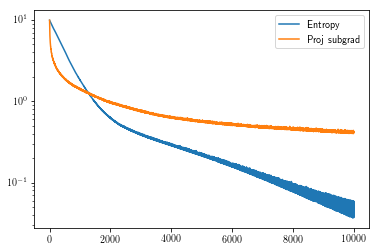

In [155]:
plt.semilogy([f(x) for x in conv_entr], label="Entropy")
plt.semilogy([f(x) for x in conv_projsub], label="Proj subgrad")
plt.legend()

## Subgradient method

- Analogue of gradient descent but for non-smooth convex function 
$$
x_{k+1} = x_k - \alpha_k g_k,
$$
where $g_k$ is subgradient in $x_k$
- What is difference with gradient descent?

### Step size selection

- Constant
- Decreasing sequence $\alpha_k \to 0$ and $\sum_{k=1}^{\infty} \alpha_k = \infty$

### Convergence analysis

- $\|x_{k+1} - x^*\|_2 = \|x_k - \alpha_k g_k - x^*\| \leq \|x_k - x^*\|_2 - 2\alpha_k g^{\top}_k(x_k - x^*) + \alpha^2_k \|g\|_2^2 \leq \|x_k - x^*\|_2 - 2\alpha_k (f(x_k) - f^*) + \alpha^2_k \|g\|_2^2$
- Using the best function value after $k$ iterations $f_{best}^{(k)}$
$$
2 \left(\sum_{i=1}^k \alpha_i\right) (f^{(k)}_{best} - f^*) \leq \| x_0 - x^*\|_2^2 - \|x_k - x^* \|_2^2 + \sum_{i=1}^k \alpha^2_i \|g_i\|_2^2 \leq \| x_0 - x^*\|_2^2 + \sum_{i=1}^k \alpha^2_i \|g_i\|_2^2
$$

#### Constant step size

$$
f^{(k)}_{best} - f^* \leq \frac{\| x_0 - x^*\|_2^2}{2k\alpha} + \frac{G^2 \alpha}{2}
$$

- What is $G$?
- Is here convergence in $f$?

### Decreasing sequence

- $\alpha_i \to 0$ and $\sum_i^{\infty}\alpha_i = \infty$

$$
f^{(k)}_{best} - f^* \leq \frac{\| x_0 - x^*\|_2^2 + G^2 \sum_{i=1}^k \alpha_i^2}{2\sum_{i=1}^k \alpha_i}
$$

### Experiment

$$
\|Ax - b\|_1 \to \min_x
$$

In [156]:
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

m, n = 500, 100
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A.dot(x_true)

In [157]:
f = lambda x: np.linalg.norm(A.dot(x) - b, 1)
subgrad = lambda x: A.T.dot(np.sign(A.dot(x) - b))

sg_methods = {
    "SM 1 / k": methods.fo.SubgradientMethod(f, subgrad, ss.InvIterStepSize()),
    "SM fixed": methods.fo.SubgradientMethod(f, subgrad, ss.ConstantStepSize(1e-3)),
    "SM scaled fix": methods.fo.SubgradientMethod(f, subgrad, 
                                                  ss.ScaledConstantStepSize(1.)),
}

In [158]:
x0 = np.random.randn(n)
max_iter = 15000

In [159]:
for m in sg_methods:
    _ = sg_methods[m].solve(x0=x0, max_iter=max_iter)

Text(0, 0.5, 'Objective, $f(x_k)$')

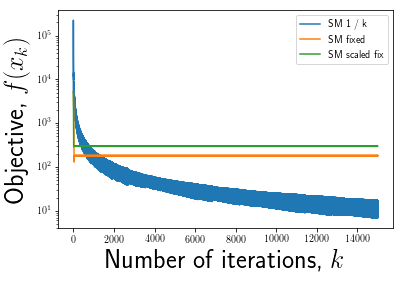

In [160]:
for m in sg_methods:
    plt.semilogy([f(x) for x in sg_methods[m].get_convergence()], label=m)
plt.legend()
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Objective, $f(x_k)$", fontsize=26)